In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis, entropy
import torch

In [2]:
df=pd.read_csv("data.csv", encoding="latin1", on_bad_lines='skip')
x=df["no2"].dropna().values.reshape(-1,1)
x

/tmp/ipython-input-2895481171.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("data.csv", encoding="latin1", on_bad_lines='skip')


array([[17.4],
       [ 7. ],
       [28.5],
       ...,
       [45. ],
       [50. ],
       [46. ]])

In [3]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_norm=scaler.fit_transform(x).flatten()
x_norm

array([-0.45449893, -1.01656799,  0.1454017 , ...,  1.03714589,
        1.3073714 ,  1.09119099])

In [4]:
r=102303707
ar=0.05*(r%7)
br=0.3*(r%5+1)
print(ar,br)
z_raw=x_norm+ar * np.sin(br*x_norm)
z_raw

0.1 0.8999999999999999


array([-0.49427263, -1.09581883,  0.15845054, ...,  1.11751254,
        1.39970327,  1.17435596])

In [5]:
mu_raw = np.mean(z_raw)
var_raw = np.var(z_raw)
lam_raw = 1 / (2 * var_raw)
c_raw = 1 / np.sqrt(2 * np.pi * var_raw)
mu_raw, var_raw, lam_raw, c_raw

(np.float64(-0.01062456215389726),
 np.float64(1.077213363947703),
 np.float64(0.4641605987579209),
 np.float64(0.3843785989901544))

In [6]:
z_clip = np.clip(z_raw, -3, 3)

In [7]:
mu_clip = np.mean(z_clip)
var_clip = np.var(z_clip)

lam_clip = 1 / (2 * var_clip)
c_clip = 1 / np.sqrt(2 * np.pi * var_clip)

In [8]:
z_torch = torch.tensor(z_raw, dtype=torch.float32)

mu_ml = torch.tensor(0.0, requires_grad=True)
log_lam = torch.tensor(0.0, requires_grad=True)

optimizer = torch.optim.Adam([mu_ml, log_lam], lr=0.05)

for _ in range(1000):
    optimizer.zero_grad()
    lam_ml = torch.exp(log_lam)
    loss = torch.mean(
        lam_ml * (z_torch - mu_ml)**2 - 0.5 * torch.log(lam_ml)
    )
    loss.backward()
    optimizer.step()

mu_ml_val = mu_ml.item()
lam_ml_val = torch.exp(log_lam).item()

var_ml = 1 / (2 * lam_ml_val)
c_ml = 1 / np.sqrt(2 * np.pi * var_ml)

In [9]:
print("RAW PDF:", mu_raw, lam_raw, c_raw)
print("CLIPPED PDF:", mu_clip, lam_clip, c_clip)
print("ML PDF:", mu_ml_val, lam_ml_val, c_ml)

print("Skewness:", skew(z_raw))
print("Kurtosis:", kurtosis(z_raw, fisher=False))

RAW PDF: -0.01062456215389726 0.4641605987579209 0.3843785989901544
CLIPPED PDF: -0.03507279575319785 0.6079866758855813 0.4399183669755113
ML PDF: -0.010624556802213192 0.4641604721546173 0.38437854656907006
Skewness: 3.3196715821936555
Kurtosis: 43.938040881300836


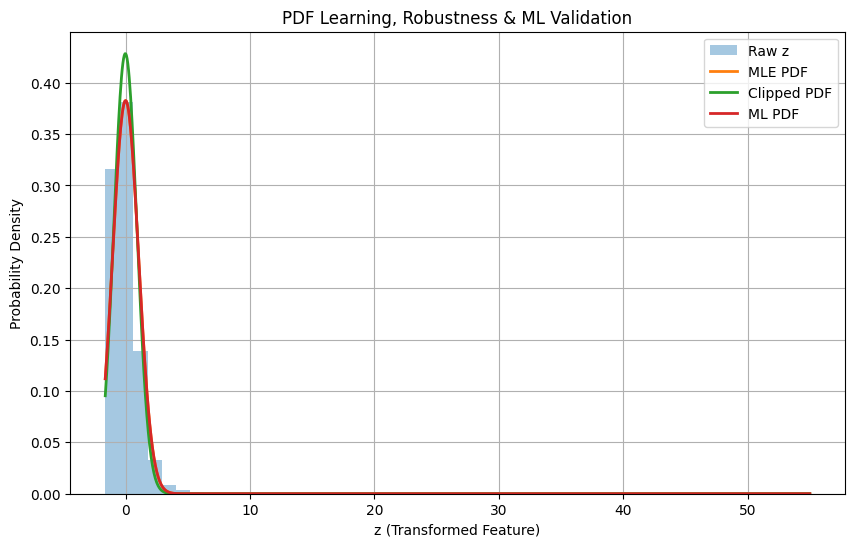

In [12]:
z_line = np.linspace(z_raw.min(), z_raw.max(), 1000)

pdf_raw = c_raw * np.exp(-lam_raw * (z_line - mu_raw)**2)
pdf_clip = c_clip * np.exp(-lam_clip * (z_line - mu_clip)**2)
pdf_ml = c_ml * np.exp(-lam_ml_val * (z_line - mu_ml_val)**2)

plt.figure(figsize=(10, 6))
plt.hist(z_raw, bins=50, density=True, alpha=0.4, label="Raw z")
plt.plot(z_line, pdf_raw, label="MLE PDF", linewidth=2)
plt.plot(z_line, pdf_clip, label="Clipped PDF", linewidth=2)
plt.plot(z_line, pdf_ml, label="ML PDF", linewidth=2)

plt.title("PDF Learning, Robustness & ML Validation")
plt.xlabel("z (Transformed Feature)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()